[next up](#here)

In [1]:
import numpy as np
import pandas as pd

import pyphi.data_models as dm  # Prototype code
from pyphi.convert import sbs2sbn, sbn2sbs      

import pyphi
import numpy as np
from pprint import pprint

pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.PICK_SMALLEST_PURVIEW = True
pyphi.config.VALIDATE_SUBSYSTEM_STATES = False

# Suppose that a prisoner dies either if A loads B’s gun and B shoots, or if C loads and shoots his gun.
# D = (A and B) or C
# Most intersting state: 101 -> 1. Here they don't want to say that A was a cause of D.

# Constants
# ============================================================================
#! NODES = 4
#! States = 2**NODES

#INI_STATE = (1, 0, 1, 1)
#cm0 = np.array([
#    [0, 0, 0, 1],
#    [0, 0, 0, 1],
#    [0, 0, 0, 1],
#    [0, 0, 0, 0]
#])

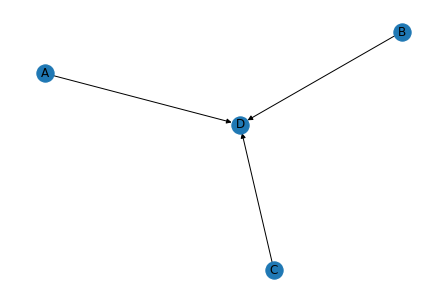

In [2]:
INI_STATE ='1010'
edges = [(0,3),(1,3),(2,3)]
net = dm.Net(edges=edges, SpN=2)
net.draw()
#print(f'Self-loops do not plot.  Actual edges = {[(i,j) for i,j in net.graph.edges()]}')

In [3]:
list(net.graph)

['A', 'B', 'C', 'D']

In [4]:
# Functions
# ============================================================================
def node_logic(*in_states):  # MODIFIED for v2 -sp-
    out_state = (in_states[0] and in_states[1]) or in_states[2]
    return out_state

net.get_node('D').func = node_logic
net.get_node('A').num_states = 3 # just to prove we can!
ps = INI_STATE #  Past State
cs = net.states.next_state(ps) # Current State
print(f'ps={ps} cs={cs}')

ps=1010 cs=1011


## TPM  
The mapping from the states of 3 input nodes (A,B,C) to the state of one output node (D) is done by a func of N args ("node_logic") attached to node D.

In [5]:
probs = np.array([[0.68893508, 0.40176953],
                      [0.44095309, 0.84035902],
                      [0.09975545, 0.58225631],
                      [0.86475645, 0.18650795],
                      [0.50721989, 0.86299773],
                      [0.62045787, 0.90525779],
                      [0.88270204, 0.46225991],
                      [0.51548114, 0.89159624]])
tpm = dm.TransProb(in_nodes=list('ABC'), out_nodes=list('D'), probabilities=probs)
#tpm.df.loc[:,:] = 9
tpm.df.loc['001',:] = [1,2]
tpm.df

,0,1
000,0.688935,0.401770
001,1.000000,2.000000
010,0.099755,0.582256
011,0.864756,0.186508
100,0.507220,0.862998
101,0.620458,0.905258
110,0.882702,0.462260
111,0.515481,0.891596


In [6]:
net.node_lut

{'A': 0, 'B': 1, 'C': 2, 'D': 3}

#### For All possible states, run mechanisms to get next state
Nodes default to noop mechanism. Node D set to node_logic. Three states for A.

In [7]:
[(s,net.states.next_state(s)) for s in net.states.gen_all_states()]

[('0000', '0000'),
 ('0001', '0000'),
 ('0010', '0011'),
 ('0011', '0011'),
 ('0100', '0100'),
 ('0101', '0100'),
 ('0110', '0111'),
 ('0111', '0111'),
 ('1000', '1000'),
 ('1001', '1000'),
 ('1010', '1011'),
 ('1011', '1011'),
 ('1100', '1101'),
 ('1101', '1101'),
 ('1110', '1111'),
 ('1111', '1111'),
 ('2000', '2000'),
 ('2001', '2000'),
 ('2010', '2011'),
 ('2011', '2011'),
 ('2100', '2101'),
 ('2101', '2101'),
 ('2110', '2111'),
 ('2111', '2111')]

In [8]:
list(tpm.df.columns)

['0', '1']

In [9]:
tpm.df.loc['001','1']

2.0

#### This function is not generalized enough!!!

In [10]:
states = dm.States(net)
dm.fill_using_mechanism(tpm,states)
tpm.df  # (A and B) or C

,0,1
000,1.0,0.0
001,0.0,1.0
010,1.0,0.0
011,0.0,1.0
100,1.0,0.0
101,0.0,1.0
110,0.0,1.0
111,0.0,1.0


# Needs work beyond here !!! @@@ <a id=here>

In [12]:
#ps = tuple([int(e > 0.5) for e in state_evo[0]])
#cs = tuple([int(e > 0.5) for e in state_evo[1]])

transition = pyphi.Transition(net, ps, cs, (0,1,2), (3,))       

AttributeError: 'list' object has no attribute 'coerce_to_indices'

In [ ]:
account = pyphi.actual.account(transition)
print(account)

#import pdb; pdb.set_trace() 
print('---------------------------')

all_accounts = pyphi.actual.nexus(net, ps, cs)
all_accounts = sorted(all_accounts, key=lambda nexus: nexus.alpha, reverse=True)

pprint([(a.transition, a.alpha) for a in all_accounts])
# print(nexi[0])
# ac.context_print_mice(nexi[0].context)

In [ ]:
   for psi in range(States):
        ps = tuple(map(int, bin(psi)[2:].zfill(NODES)[::-1]))      
        tpm[psi, :] = node_logic(ps)

    state_evo = state_evolution(INI_STATE, 1)
    print(state_evo)
    print('---------------------------')
    
    print(f'tpm.shape={tpm.shape}')
    pd.DataFrame(tpm)
  

In [ ]:
cm = dm.CM()
cm.from_legacy(cm=cm0, labels=list('ABCD'))
cm.df

In [ ]:
    net = pyphi.Network(tpm, cm)

    ps = tuple([int(e > 0.5) for e in state_evo[0]])
    cs = tuple([int(e > 0.5) for e in state_evo[1]])

    transition = pyphi.Transition(net, ps, cs, (0,1,2), (3,))       
    
    account = pyphi.actual.account(transition)
    print(account)

    #import pdb; pdb.set_trace() 
    print('---------------------------')

    all_accounts = pyphi.actual.nexus(net, ps, cs)
    all_accounts = sorted(all_accounts, key=lambda nexus: nexus.alpha, reverse=True)

    pprint([(a.transition, a.alpha) for a in all_accounts])
    # print(nexi[0])
    # ac.context_print_mice(nexi[0].context)

    #! import pdb; pdb.set_trace() 

In [ ]:
len(cm0)

In [ ]:
cwd

In [ ]:
%cwd

In [ ]:
pwd